# Imports

In [188]:
"""
A model that captures general features of data
"""

import tensorflow as tf
import numpy as np
import tensorflow.keras as keras
from matplotlib import pyplot as plt

# Dataset

In [189]:
#load in dataset
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
#normalize image values
x_train, x_test = x_train/255.0, x_test/255.0

In [190]:
#add a channels dimension to the images
x_train = np.expand_dims(x_train,3).astype("float32")
x_test = np.expand_dims(x_test,3).astype("float32")

In [191]:
#shuffle and batch
ds_train = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(10000).batch(32)
ds_test = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(32)

# Model

In [192]:
#okay, there are several things to try
  #no dropout ✓ Doesn't seem to overfit here, test loss is same as training 
  #mess with dropout values ✓ .014 w/o dropout, .024 w/ dropout(.1), .042 w/ dropout(.5), apparently dropout can really kill performance
  #use convolutions ✓ .014 with 11,433,979 params, ran another 10 epochs and it overfit, doesn't look any better really, but no worse either
  #bigger model ✓ .019 -> .014 on 219,546 params -> 1,150,874 params
  #different loss ✓ MSE, MAE, MSLE all worked enough to tell what it was, MAE works best though
  #possibly frozen encoder ✓ won't do but seems like a cool idea

In [193]:
class EncoderDecoder(keras.Model):
  def __init__(self):
    super(EncoderDecoder, self).__init__()
    #encode
    self.conv = keras.layers.Conv2D(16, 3, activation='relu', input_shape=(28,28,1))
    self.flatten = keras.layers.Flatten()
    self.d_1 = keras.layers.Dense(512, activation='relu')
    self.d0  = keras.layers.Dense(256, activation='relu')
    self.d1  = keras.layers.Dense(128, activation='relu')
    self.drop1 = keras.layers.Dropout(.25)
    self.d2 = keras.layers.Dense(64, activation='relu')
    # self.drop2 = keras.layers.Dropout(.5)
    self.d3 = keras.layers.Dense(10)
    #decode
    self.dd1 = keras.layers.Dense(64, activation='relu')
    # self.ddrop1 = keras.layers.Dropout(.5)
    self.dd2 = keras.layers.Dense(128, activation='relu')
    self.ddrop2 = keras.layers.Dropout(.25)
    self.dd_21 = keras.layers.Dense(256, activation='relu')
    self.dd_22 = keras.layers.Dense(512, activation='relu')
    self.dd3 = keras.layers.Dense(10816)
    self.unflatten = keras.layers.Reshape((26,26,16))
    self.convTrans = keras.layers.Conv2DTranspose(1, 3)

  def call(self, x, training):
    x = self.encode(x, training)
    return self.decode(x, training)
  
  def encode(self, x, training):
    x = self.conv(x)
    x = self.flatten(x)
    x = self.d_1(x)
    x = self.d0(x)
    x = self.d1(x)
    if training:
      x = self.drop1(x)
    x = self.d2(x)
    # if training:
    #   x = self.drop2(x)
    x = self.d3(x)
    return x

  def decode(self, x, training):
    x = self.dd1(x)
    # if training:
    #   x = self.ddrop1(x)
    x = self.dd2(x)
    x = self.dd_21(x)
    x = self.dd_22(x)
    if training:
      x = self.ddrop2(x)
    x = self.dd3(x)
    x = self.unflatten(x)
    x = self.convTrans(x)
    return x
  
model = EncoderDecoder()
mse_loss = keras.losses.MeanAbsoluteError()
optimizer = keras.optimizers.Adam()

train_loss = keras.metrics.Mean(name='train_loss')

test_loss = keras.metrics.Mean(name='test_loss')

# Training & Testing

In [194]:
@tf.function
def train_step(images):
  #train
  with tf.GradientTape() as tape:
    predictions = model(images, training = True)
    losses = mse_loss(images, predictions)
  gradients = tape.gradient(losses, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  #metrics
  train_loss(losses)

@tf.function
def test_step(images):
  #inference
  predictions = model(images, training = False)
  t_losses = mse_loss(images, predictions)
  #metrics
  test_loss(t_losses)

In [195]:
EPOCHS = 10
for epoch in range(EPOCHS):
  #reset metrics
  train_loss.reset_states()
  test_loss.reset_states()

  #training step
  for images, labels in ds_train:
    train_step(images)
  
  #testing step
  for images, labels in ds_test:
    test_step(images)

  #print some info
  print(
      f'Epoch {epoch+1}',
      f'Loss {train_loss.result()}',
      f'Test Loss {test_loss.result()}',
  )

Epoch 1 Loss 0.09193918108940125 Test Loss 0.07651039958000183
Epoch 2 Loss 0.07952821254730225 Test Loss 0.07236706465482712
Epoch 3 Loss 0.07688069343566895 Test Loss 0.06935757398605347
Epoch 4 Loss 0.07520005851984024 Test Loss 0.06776375323534012
Epoch 5 Loss 0.07396279275417328 Test Loss 0.06708741188049316
Epoch 6 Loss 0.07293051481246948 Test Loss 0.06627456098794937
Epoch 7 Loss 0.07211936265230179 Test Loss 0.0643574595451355
Epoch 8 Loss 0.07126937806606293 Test Loss 0.06504753232002258
Epoch 9 Loss 0.07065003365278244 Test Loss 0.06352800875902176
Epoch 10 Loss 0.06992575526237488 Test Loss 0.06350993365049362
Epoch 11 Loss 0.06938954442739487 Test Loss 0.06415051221847534
Epoch 12 Loss 0.06886643171310425 Test Loss 0.06246212124824524
Epoch 13 Loss 0.06830962002277374 Test Loss 0.06303320080041885
Epoch 14 Loss 0.06781937927007675 Test Loss 0.06334882974624634
Epoch 15 Loss 0.0673375353217125 Test Loss 0.06176459789276123
Epoch 16 Loss 0.06697911024093628 Test Loss 0.06313

In [163]:
i = iter(ds_test)
sample, label = next(i)
x = model(sample, training = False)
print(model.count_params())

11433979


# Efficacy Testing

6 (28, 28)


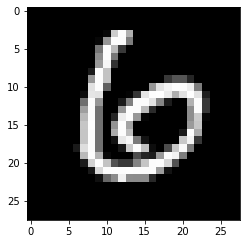

In [207]:
#get image
index = np.random.randint(0,32)
it = iter(ds_test)
images, labels = next(it)
image = images[index].numpy().reshape((28,28))
label = labels[index]
latent = model.encode(images, training = False)[index].numpy().reshape((1,10)) #need to act like its a batch
out = model.decode(latent, training = False)[0].numpy().reshape((28,28))
print(label.numpy(), out.shape)

# Set the figure size
plt.rcParams["figure.figsize"] = [7.00, 3.50]
plt.rcParams["figure.autolayout"] = True

# Plot the data using imshow with gray colormap
plt.imshow(image, cmap='gray')

# Display the plot
plt.show()

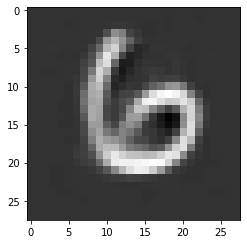

In [208]:
plt.imshow(out, cmap='gray')